In [13]:
# imports
import os
import requests
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# load etherscan API key from .env file
load_dotenv()
etherscankey = os.getenv("etherscankey")
if not etherscankey:
    raise ValueError("Etherscan API key not found. Please set 'etherscankey' in your .env file.")

In [14]:
# a new function to get rtansactions
def get_transactions(address, start_block=0, end_block=99999999, limit=20):
    # base url
    url = "https://api.etherscan.io/api"
    # parameters
    params = {
        "module": "account",
        "action": "txlist",
        "address": address,
        "startblock": start_block,
        "endblock": end_block,
        "sort": "desc",  # newest first
        "apikey": etherscankey # put in api key
    }
    # send req
    response = requests.get(url, params=params)
    # respond as json
    data = response.json()
    # check status
    if data["status"] != "1":
        raise Exception(f"Error fetching data: {data.get('message')}")
    # return value!
    return data["result"][:limit]


In [18]:
# example wallet vitalick buterin’s ens-linked wallet
# wallet_address = "0xd8dA6BF26964aF9D7eEd9e03E53415D37aA96045"

# googled possile sus wallet
wallet_address = "0xab8bd0d4eda57cd9ee5a058e498a791df13dfa65"

# fetch transactions with my little function 
transactions = get_transactions(wallet_address, limit=15)
# print number of transactions fetched
print(f"Fetched {len(transactions)} transactions for {wallet_address}")


Fetched 15 transactions for 0xab8bd0d4eda57cd9ee5a058e498a791df13dfa65


In [19]:
# time to build grpah
def build_graph(transactions):
    # initialize directed graph
    G = nx.DiGraph()
    # iterate in ttransactions
    for tx in transactions:
        # send and from
        sender = tx["from"]
        receiver = tx["to"]
        # add nodes and edges
        G.add_node(sender)
        G.add_node(receiver)
        G.add_edge(sender, receiver, value=int(tx["value"]))
    # return graph
    return G

# build graph from transactions
G = build_graph(transactions)
# counting
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph has 10 nodes and 9 edges.


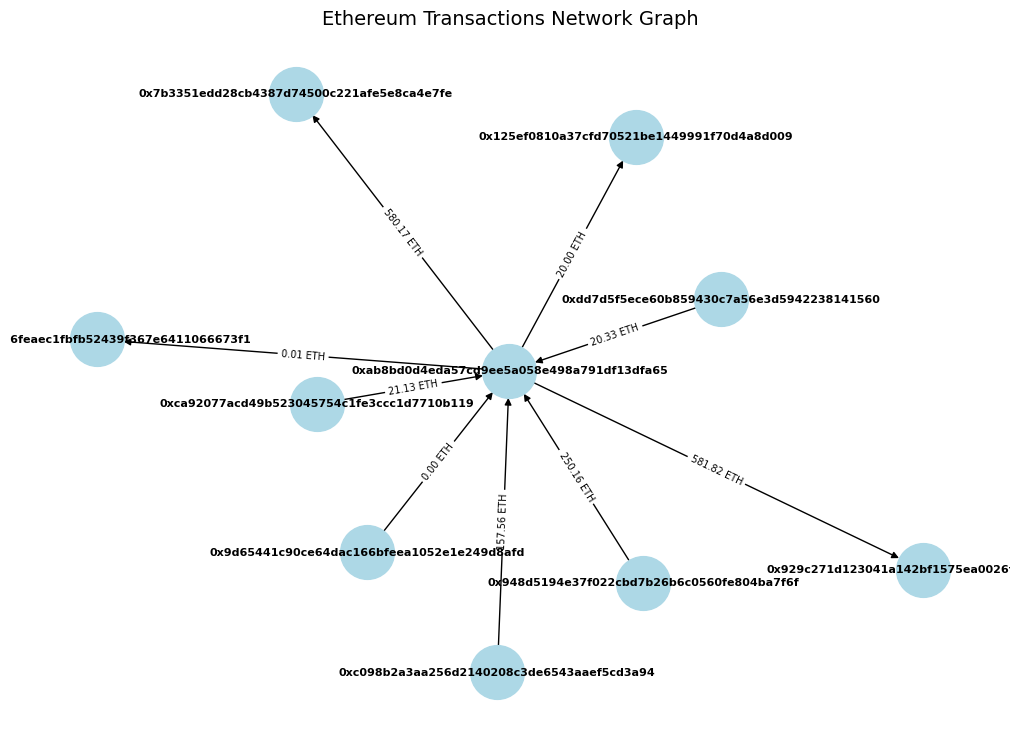

In [20]:
# set up plot
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5, iterations=20)

# draw graph
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="lightblue", font_size=8, font_weight="bold", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u,v): f"{d['value']/1e18:.2f} ETH" for u,v,d in G.edges(data=True)}, font_size=7)

# show + title
plt.title("Ethereum Transactions Network Graph", fontsize=14)
plt.show()


In [21]:
# little function to check for sus
def analyze_transactions(transactions, high_value_threshold=100):
    # initialize variables
    suspicious = []
    total_eth = 0

    # check every transaction
    for tx in transactions:
        value_eth = int(tx["value"]) / 1e18
        total_eth += value_eth

        # high value transaction can be sus
        if value_eth >= high_value_threshold:
            # add to sus list
            suspicious.append({
                "hash": tx["hash"],
                "from": tx["from"],
                "to": tx["to"],
                "value": value_eth,
                "reason": f"High value ({value_eth:.2f} ETH)"
            })

        # loop the send is also sus
        if tx["from"].lower() == tx["to"].lower():
            # add to sus list
            suspicious.append({
                "hash": tx["hash"],
                "from": tx["from"],
                "to": tx["to"],
                "value": value_eth,
                "reason": "Self-transfer"
            })

    # calculate averages and max
    avg_tx = total_eth / len(transactions) if transactions else 0
    max_tx = max(int(tx["value"]) for tx in transactions) / 1e18 if transactions else 0

    # return insights
    return {
        "total_tx": len(transactions),
        "total_eth": total_eth,
        "avg_tx": avg_tx,
        "max_tx": max_tx,
        "suspicious": suspicious
    }

# analyze transactions and print
insights = analyze_transactions(transactions, high_value_threshold=50) 
insights


{'total_tx': 15,
 'total_eth': 2167.70228254643,
 'avg_tx': 144.51348550309532,
 'max_tx': 581.82,
 'suspicious': [{'hash': '0x77b64fb9f36b88ce00b2b758da1880ed60e0ef477ce01b2925771346675dca95',
   'from': '0xab8bd0d4eda57cd9ee5a058e498a791df13dfa65',
   'to': '0x929c271d123041a142bf1575ea0026f1d8fa7c49',
   'value': 581.82,
   'reason': 'High value (581.82 ETH)'},
  {'hash': '0x09c51775eaedc25a77292a044ce1b6476d7b411f060b799510d6c2b4d691d86d',
   'from': '0x948d5194e37f022cbd7b26b6c0560fe804ba7f6f',
   'to': '0xab8bd0d4eda57cd9ee5a058e498a791df13dfa65',
   'value': 250.16494616825338,
   'reason': 'High value (250.16 ETH)'},
  {'hash': '0x80afc3997bc1c9e7caf93378677fa24468e8befb9e0ad2a48148b0098478451d',
   'from': '0xab8bd0d4eda57cd9ee5a058e498a791df13dfa65',
   'to': '0x7b3351edd28cb4387d74500c221afe5e8ca4e7fe',
   'value': 580.16512,
   'reason': 'High value (580.17 ETH)'},
  {'hash': '0x74dad7a7b41c99494ccd6046e00926c584103ce5fbfd7f500b52c0aad581ab6e',
   'from': '0xc098b2a3aa256d2

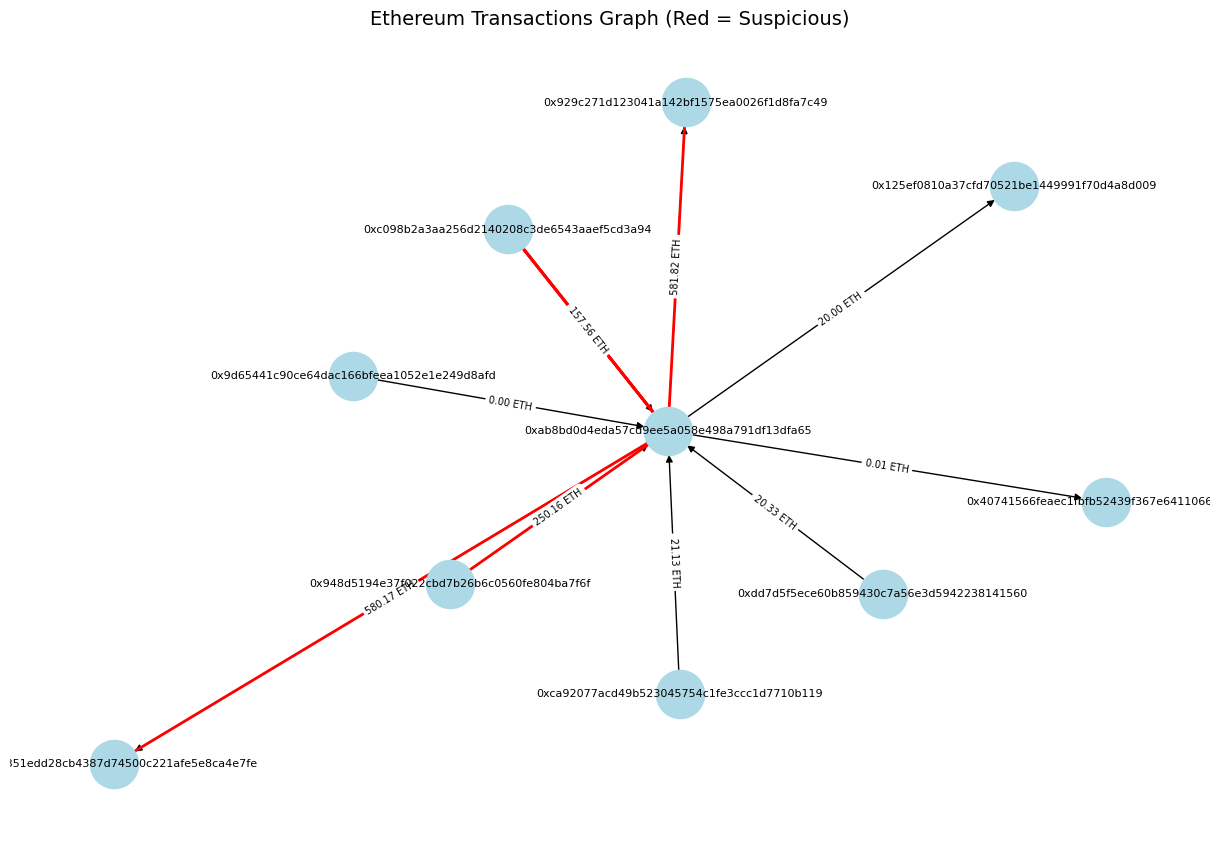

In [22]:
# visual but flagged this time
def visualize_with_flags(G, suspicious):
    # set up plot
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, iterations=20)

    # default draw
    nx.draw(G, pos, with_labels=True, node_size=1200, node_color="lightblue", font_size=8, arrows=True)

    # red highlighter for sus
    suspicious_edges = [(s["from"], s["to"]) for s in suspicious]
    nx.draw_networkx_edges(G, pos, edgelist=suspicious_edges, edge_color="red", width=2)

    # edge labels
    edge_labels = {(u,v): f"{d['value']/1e18:.2f} ETH" for u,v,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    # title and show
    plt.title("Ethereum Transactions Graph (Red = Suspicious)", fontsize=14)
    plt.show()

visualize_with_flags(G, insights["suspicious"])


In [23]:
# print suspicious transactions
if insights["suspicious"]:
    print("suspicious detect:")
    for s in insights["suspicious"]:
        print(f"- {s['hash']} | {s['from']} → {s['to']} | {s['value']:.2f} ETH | Reason: {s['reason']}")
else:
    print("less sus")


suspicious detect:
- 0x77b64fb9f36b88ce00b2b758da1880ed60e0ef477ce01b2925771346675dca95 | 0xab8bd0d4eda57cd9ee5a058e498a791df13dfa65 → 0x929c271d123041a142bf1575ea0026f1d8fa7c49 | 581.82 ETH | Reason: High value (581.82 ETH)
- 0x09c51775eaedc25a77292a044ce1b6476d7b411f060b799510d6c2b4d691d86d | 0x948d5194e37f022cbd7b26b6c0560fe804ba7f6f → 0xab8bd0d4eda57cd9ee5a058e498a791df13dfa65 | 250.16 ETH | Reason: High value (250.16 ETH)
- 0x80afc3997bc1c9e7caf93378677fa24468e8befb9e0ad2a48148b0098478451d | 0xab8bd0d4eda57cd9ee5a058e498a791df13dfa65 → 0x7b3351edd28cb4387d74500c221afe5e8ca4e7fe | 580.17 ETH | Reason: High value (580.17 ETH)
- 0x74dad7a7b41c99494ccd6046e00926c584103ce5fbfd7f500b52c0aad581ab6e | 0xc098b2a3aa256d2140208c3de6543aaef5cd3a94 → 0xab8bd0d4eda57cd9ee5a058e498a791df13dfa65 | 130.39 ETH | Reason: High value (130.39 ETH)
- 0xec680a4d5cc53029fe1d85e137763d8959c192494dc89e0ce76ed1f2143af1c9 | 0xc098b2a3aa256d2140208c3de6543aaef5cd3a94 → 0xab8bd0d4eda57cd9ee5a058e498a791df13dfa6